## 2量子ビット量子加算回路
古典の加算回路を量子半加算器と量子全加算器で置換  
![2qubits-additive-circuit](2qubits-additive-circuit.png)

In [30]:
# Import the qiskit library
#量子ビット
from qiskit import QuantumCircuit

#シミュレータ
from qiskit_aer import StatevectorSimulator

#ブロッホ球表示
from qiskit.visualization import plot_bloch_multivector

#シミュレータとパスマネージャとサンプラとグラフ化
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

#表示をクリア
from IPython.display import clear_output

## 量子ビット、古典ビットの用意  
- q₀ : |A₀〉  
- q₁ : |B₀〉  
- q₂ : Work Bit |0〉⇒|S₀〉=c₂
- q₃ : Ancilla Bit |0〉⇒|Cin〉
- q₄ : |A₁〉
- q₅ : |B₁〉
- q₆,q₇,q₈ : Ancilla Bit |0〉
- q₉,q₁₀: Work Bit |0〉⇒|Cout〉=c₀,|S₁〉=c₁
- c₀,c₁,C₂ : 古典ビット  
**条件：|Cout〉と|S〉を並べて表示**  
『Pythonではじめる量子AI入門 量子機械学習から量子回路自動設計まで (エンジニア入門シリーズ)』1.4.1項問題7から  
https://amzn.asia/d/aeMSoG8

In [39]:
#量子ビット11、と古典ビット3つ用意
qc = QuantumCircuit(11,3) #11量子ビット、3古典ビットを準備

## 入力状態を設定

In [50]:
def setup_input_state(qc, state_num):
    """
    量子回路の入力状態を設定する関数
    
    Parameters:
    qc (QuantumCircuit): 設定対象の量子回路
    state_num (int): 設定したい状態番号（1-8）
    
    Returns:
    QuantumCircuit: 入力設定された量子回路
    """
    # すべての以前の操作をクリア（新しい回路を作る場合は不要）
    qc.data.clear()
    
    if state_num == 1:
        # すべてのビットを反転 (q₀,q₁,q₄,q₅ = 1111)
        # 結果: |110⟩ (1+1+1+1=4)
        qc.x([0,1,4,5])
    elif state_num == 2:
        # q₀,q₁,q₄を反転 (q₀,q₁,q₄,q₅ = 1110)
        # 結果: |101⟩ (1+1+1+0=3)
        qc.x([0,1,4])
    elif state_num == 3:
        # q₀,q₁,q₅を反転 (q₀,q₁,q₄,q₅ = 1101)
        # 結果: |101⟩ (1+1+0+1=3)
        qc.x([0,1,5])
    elif state_num == 4:
        # q₀,q₄,q₅を反転 (q₀,q₁,q₄,q₅ = 1011)
        # 結果: |101⟩ (1+0+1+1=3)
        qc.x([0,4,5])
    elif state_num == 5:
        # q₁,q₄,q₅を反転 (q₀,q₁,q₄,q₅ = 0111)
        # 結果: |101⟩ (0+1+1+1=3)
        qc.x([1,4,5])
    elif state_num == 6:
        # q₀,q₁を反転 (q₀,q₁,q₄,q₅ = 1100)
        # 結果: |010⟩ (1+1+0+0=2)
        qc.x([0,1])
    elif state_num == 7:
        # q₄,q₅を反転 (q₀,q₁,q₄,q₅ = 0011)
        # 結果: |010⟩ (0+0+1+1=2)
        qc.x([4,5])
    elif state_num == 8:
        # 何もしない（基底状態のまま）(q₀,q₁,q₄,q₅ = 0000)
        # 結果: |000⟩ (0+0+0+0=0)
        pass
    else:
        raise ValueError("状態番号は1から8の間で指定してください")
    
    return qc

# 使用例
def create_circuit_with_state(num_qubits, num_classical_bits, state_num):
    """
    指定された入力状態で量子回路を作成する関数
    
    Parameters:
    num_qubits (int): 量子ビット数
    num_classical_bits (int): 古典ビット数
    state_num (int): 設定したい状態番号（1-8）
    
    Returns:
    QuantumCircuit: 作成された量子回路
    """
    qc = QuantumCircuit(num_qubits, num_classical_bits)
    return setup_input_state(qc, state_num)

# 使用例
# qc = create_circuit_with_state(11, 3, 1)  # 状態1で11量子ビット、3古典ビットの回路を作成


#状態を設定
setup_input_state(qc, 6)  # 状態1（すべてのビットを反転）を設定
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(11, 'q'), 0), Qubit(QuantumRegister(11, 'q'), 1), Qubit(QuantumRegister(11, 'q'), 2), Qubit(QuantumRegister(11, 'q'), 3), Qubit(QuantumRegister(11, 'q'), 4), Qubit(QuantumRegister(11, 'q'), 5), Qubit(QuantumRegister(11, 'q'), 6), Qubit(QuantumRegister(11, 'q'), 7), Qubit(QuantumRegister(11, 'q'), 8), Qubit(QuantumRegister(11, 'q'), 9), Qubit(QuantumRegister(11, 'q'), 10)), clbits=())

## 回路を準備

In [51]:
#QHA
qc.cx(0,2)
qc.cx(1,2)
qc.ccx(0,1,3)
qc.barrier()

#QFA
qc.cx(4,6)
qc.cx(5,6)
qc.ccx(4,5,7)
qc.cx(3,10)
qc.cx(6,10)
qc.ccx(3,6,8)
qc.cx(7,9)
qc.cx(8,9)
qc.ccx(7,8,9)
qc.barrier()

#unconputing
qc.ccx(3,6,8)
qc.ccx(4,5,7)
qc.cx(5,6)
qc.cx(4,6)
qc.ccx(0,1,3)
qc.barrier()

#measure
qc.measure(2,0)
qc.measure(10,1)
qc.measure(9,2)


## 回路図を表示

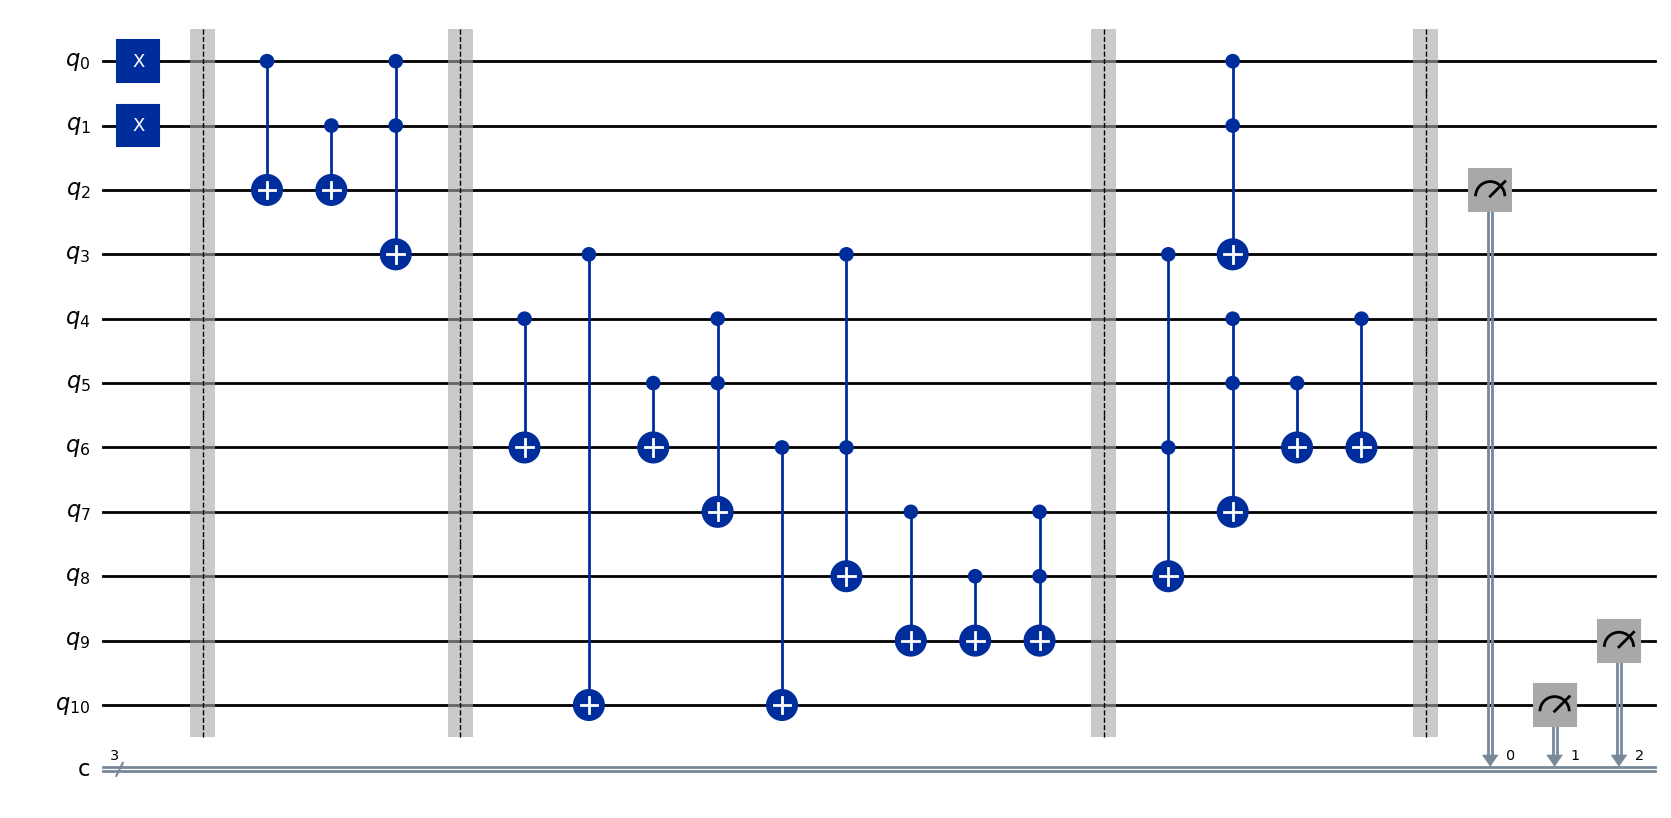

In [52]:
#表示をクリア
clear_output(wait=True)

#回路図を表示
qc.draw(output="mpl")

## シミュレータで実行
コードはデッドコピー

 > Counts: {'010': 1024}


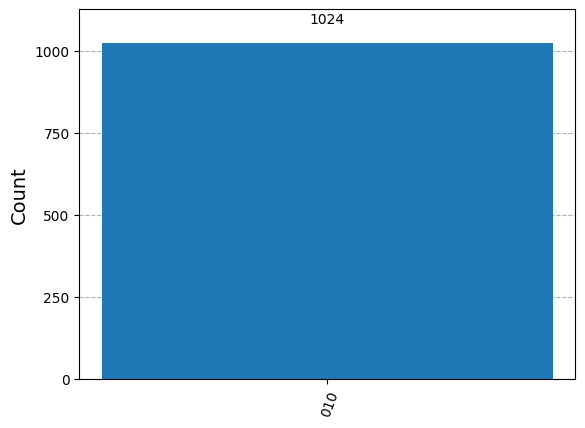

In [53]:
#【VERBATIM CODE COPY : Simulator】

#シミュレータを準備
backend = AerSimulator()

#パスマネージャを準備
passmanager = generate_preset_pass_manager(backend=backend, optimization_level=1)

#回路を最適化
isa_circuit = passmanager.run(qc)

#シミュレータからサンプラを作って実行
sampler = Sampler(backend)
job  = sampler.run([isa_circuit])
result = job.result()

#測定された回数を表示
counts = result[0].data.c.get_counts()
print(f" > Counts: {counts}")

#ヒストグラムで表示
plot_histogram( counts )

## 実機で実行
コードはデッドコピー

最も空いているバックエンドは:  <IBMBackend('ibm_brisbane')>
job id: cxntxgp3wrp0008kfqs0
 > Counts: {'100': 1168, '110': 1140, '000': 783, '010': 759, '111': 70, '101': 65, '011': 55, '001': 56}


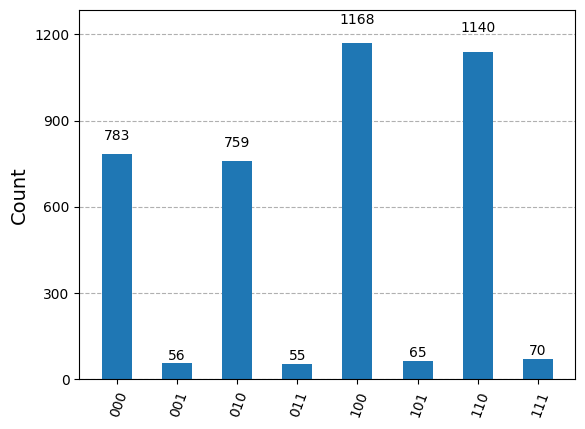

In [54]:
#【VERBATIM CODE COPY : Real device】

#実機実行時はserviceインスタンス作成が必要
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
service.backends()

#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print("最も空いているバックエンドは: ", backend)

# 回路を実機で実行可能なbasisゲートにトランスパイルします
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

# Samplerで実行します
sampler = Sampler(backend)
job = sampler.run([isa_circuit])

print("job id:", job.job_id()) # job idの確認

# ジョブの実行状態を確認します
job.status()

### job has successfully runになってから実行します ###
result = job.result()
print(f" > Counts: {result[0].data.c.get_counts()}")

from qiskit.visualization import plot_histogram
plot_histogram(result[0].data.c.get_counts())

## 補足：測定結果の順番

### 式
以下の式を実行する回路であることを前提に、測定結果の順番をチェックします。

$$
|A_1\rangle |A_0\rangle + |B_1\rangle |B_0\rangle + |C_{\text{in}}\rangle \rightarrow |C_{\text{out}}\rangle |S_1\rangle |S_0\rangle
$$

### 回路の測定部分
測定結果に対応する量子ビットと古典ビットのマッピング：
- $S_0$ → 量子ビット 2 を古典ビット 0 に測定
- $S_1$ → 量子ビット 10 を古典ビット 1 に測定
- $C_{\text{out}}$ → 量子ビット 9 を古典ビット 2 に測定

#### 順番の確認
式で求める出力の順番$S_0, S_1, C_{\text{out}}$と回路の測定順（古典ビットへの対応）が一致しています。

### 結論
測定結果の順番は **正しい** と判断されます。